# US Accidents - Opdracht 2 

#### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

#### Open file

In [2]:
US_Accidents = pd.read_csv("US_Accidents_June20.csv")

#### Remove Duplicates

In [6]:
US_Accidents = US_Accidents.drop_duplicates(subset=["Zipcode", "Start_Time", "End_Time"], keep = "first")
US_Accidents.head(5)

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


# WEATHER
Focus on Airport_Code, Weather_Timestamp, Temperature(F), Wind_Chill(F), Humidity(%), Pressure(in), Visibility(mi), Wind_Direction, Wind_Speed(mhp), Precipitation(in), Weather_Condition, Severity

### Reusable functions

In [7]:
def find_outliers_IQR(df):
    ''' Calculates the first and third quantile and uses those to find the outliers and returns them in a list '''
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

In [8]:
def F_to_C(temp):
    ''' Takes in temperature in Fahrenheit and returns the temperature in Celsius ''' 
    my_list = []
    for f in temp:
        c = (f - 32) / 1.8
        my_list.append(c)
    return my_list

### Weather timestamp 

#### Make datetime datatype for timestamps and check if timestamps are taken longer than an hour after the start of the accident

In [9]:
US_Accidents["Weather_Timestamp"].info()
US_Accidents["Weather_Timestamp"] = pd.to_datetime(US_Accidents["Weather_Timestamp"], errors="coerce")

<class 'pandas.core.series.Series'>
Int64Index: 3454567 entries, 0 to 3513616
Series name: Weather_Timestamp
Non-Null Count    Dtype 
--------------    ----- 
3412572 non-null  object
dtypes: object(1)
memory usage: 52.7+ MB


#### Make column with time difference between start accident and weather timestamp

In [10]:
US_Accidents["Start_Time"] = pd.to_datetime(US_Accidents["Start_Time"], errors="coerce")
US_Accidents["Diff_h_wt"] = US_Accidents["Start_Time"] - US_Accidents["Weather_Timestamp"] 
US_Accidents["Diff_h_wt"] = US_Accidents["Diff_h_wt"] / pd.Timedelta(hours=1)
US_Accidents["Diff_h_wt"].describe() 

count    3.412572e+06
mean    -8.936017e-03
std      5.729474e-01
min     -2.383806e+01
25%     -1.886111e-01
50%      1.111111e-03
75%      1.897222e-01
max      2.301667e+01
Name: Diff_h_wt, dtype: float64

#### Remove rows when weather timestamp is taken more than an hour from the start of the accident

In [11]:
US_Accidents = US_Accidents.drop(US_Accidents[(US_Accidents.Diff_h_wt < -1)].index)
US_Accidents = US_Accidents.drop(US_Accidents[(US_Accidents.Diff_h_wt > 1)].index)

### Temperature

In [12]:
US_Accidents["Temperature(F)"].info()
US_Accidents["Temperature(F)"].head(10)

<class 'pandas.core.series.Series'>
Int64Index: 3413597 entries, 0 to 3513615
Series name: Temperature(F)
Non-Null Count    Dtype  
--------------    -----  
3352842 non-null  float64
dtypes: float64(1)
memory usage: 52.1 MB


0    36.9
1    37.9
2    36.0
3    35.1
4    36.0
5    37.9
6    34.0
7    34.0
8    33.3
9    37.4
Name: Temperature(F), dtype: float64

In [13]:
# Make new column with temperatures in celcius
US_Accidents["Temperature(C)"] = F_to_C(US_Accidents["Temperature(F)"])

<AxesSubplot:>

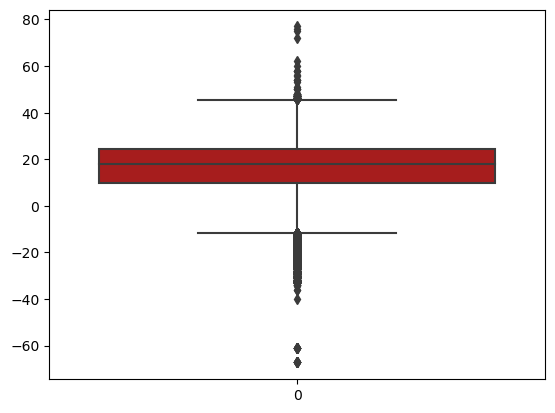

In [14]:
#sns.histplot(data = US_Accidents, x="Temperature(C)")
US_Accidents["Temperature(C)"].describe()
sns.boxplot(US_Accidents["Temperature(C)"], color="#bd0606")  

In [15]:
# Identify outliers
Temp_outliers = find_outliers_IQR(US_Accidents["Temperature(F)"])
Temp_outliers = list(set(Temp_outliers))

In [16]:
# Remove extreme temperature values
def remove_extremes(values, outliers):
    ''' Removes outliers '''
    value_outliers = outliers
    my_list = []
    for x in values:
        if x in value_outliers:
            x = np.nan
        my_list.append(x)
    return my_list
US_Accidents["Temperature(F)"] = remove_extremes(US_Accidents["Temperature(F)"], Temp_outliers)

In [17]:
# Make new column with temperatures in celcius
US_Accidents["Temperature(C)"] = F_to_C(US_Accidents["Temperature(F)"])

### Wind chill 

In [18]:
US_Accidents["Wind_Chill(F)"].info()
US_Accidents["Wind_Chill(F)"].head(10)

<class 'pandas.core.series.Series'>
Int64Index: 3413597 entries, 0 to 3513615
Series name: Wind_Chill(F)
Non-Null Count    Dtype  
--------------    -----  
1597964 non-null  float64
dtypes: float64(1)
memory usage: 52.1 MB


0     NaN
1     NaN
2    33.3
3    31.0
4    33.3
5    35.5
6    31.0
7    31.0
8     NaN
9    33.8
Name: Wind_Chill(F), dtype: float64

<AxesSubplot:>

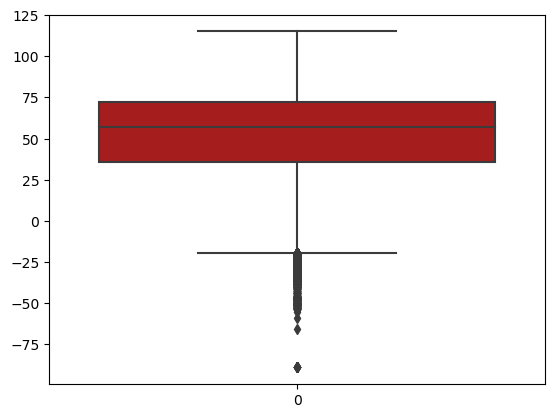

In [19]:
#sns.histplot(data = US_Accidents, x="Wind_Chill(F)")
US_Accidents["Wind_Chill(F)"].describe()
sns.boxplot(US_Accidents["Wind_Chill(F)"], color="#bd0606")  

In [20]:
WindChill_outliers = find_outliers_IQR(US_Accidents["Wind_Chill(F)"])
WindChill_outliers = list(set(WindChill_outliers))

In [21]:
US_Accidents["Wind_Chill(F)"] = remove_extremes(US_Accidents["Wind_Chill(F)"], WindChill_outliers)

In [22]:
US_Accidents["Wind_Chill(C)"] = F_to_C(US_Accidents["Wind_Chill(F)"])
US_Accidents["Wind_Chill(C)"].info()

<class 'pandas.core.series.Series'>
Int64Index: 3413597 entries, 0 to 3513615
Series name: Wind_Chill(C)
Non-Null Count    Dtype  
--------------    -----  
1594896 non-null  float64
dtypes: float64(1)
memory usage: 52.1 MB


### Humidity 

In [23]:
US_Accidents["Humidity(%)"].info()
US_Accidents["Humidity(%)"].head(10)

<class 'pandas.core.series.Series'>
Int64Index: 3413597 entries, 0 to 3513615
Series name: Humidity(%)
Non-Null Count    Dtype  
--------------    -----  
3349027 non-null  float64
dtypes: float64(1)
memory usage: 52.1 MB


0     91.0
1    100.0
2    100.0
3     96.0
4     89.0
5     97.0
6    100.0
7    100.0
8     99.0
9    100.0
Name: Humidity(%), dtype: float64

<AxesSubplot:>

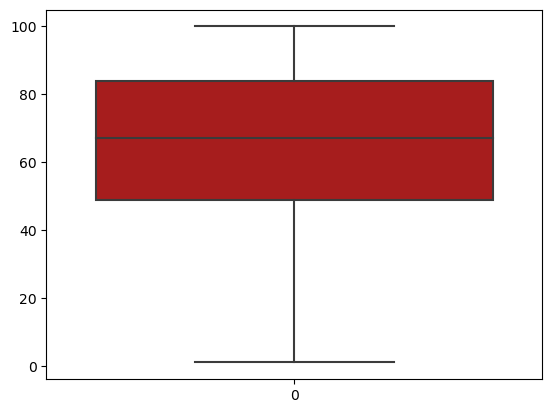

In [24]:
#sns.histplot(data = US_Accidents, x="Wind_Chill(F)")
US_Accidents["Humidity(%)"].describe()
sns.boxplot(US_Accidents["Humidity(%)"], color="#bd0606") 

### Pressure 

In [25]:
US_Accidents["Pressure(in)"].info()
US_Accidents["Pressure(in)"].head(10)

<class 'pandas.core.series.Series'>
Int64Index: 3413597 entries, 0 to 3513615
Series name: Pressure(in)
Non-Null Count    Dtype  
--------------    -----  
3361650 non-null  float64
dtypes: float64(1)
memory usage: 52.1 MB


0    29.68
1    29.65
2    29.67
3    29.64
4    29.65
5    29.63
6    29.66
7    29.66
8    29.67
9    29.62
Name: Pressure(in), dtype: float64

<AxesSubplot:>

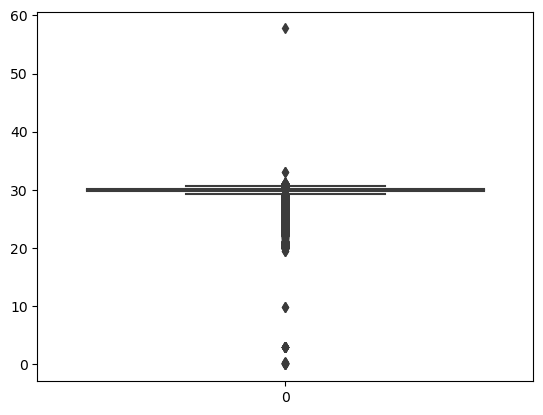

In [26]:
#sns.histplot(data = US_Accidents, x="Pressure(in)")
US_Accidents["Pressure(in)"].describe()
sns.boxplot(US_Accidents["Pressure(in)"], color="#bd0606") 

In [27]:
# Set max pressure at 32.03 inHg and minimum 26 inHg
def remove_extreme_press(pressure):
    ''' Removes pressures that are below 26 and above 32.03 (the lowest and highest recorded air pressures)'''
    my_list = []
    for x in pressure:
        if x > 32.03:
            x = np.nan
        if x < 26:
            x = np.nan
        my_list.append(x)
    return my_list
US_Accidents["Pressure(in)"] = remove_extreme_press(US_Accidents["Pressure(in)"])

### Visibility

In [72]:
US_Accidents["Visibility(mi)"].info()
#US_Accidents["Visibility(mi)"].head(10)

<class 'pandas.core.series.Series'>
Int64Index: 3413597 entries, 0 to 3513615
Series name: Visibility(mi)
Non-Null Count    Dtype  
--------------    -----  
3342582 non-null  float64
dtypes: float64(1)
memory usage: 52.1 MB


<AxesSubplot:>

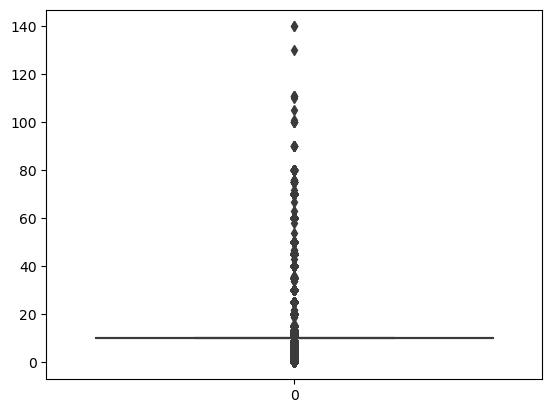

In [29]:
#sns.histplot(data = US_Accidents, x="Visibility(mi)")
US_Accidents["Visibility(mi)"].describe()
sns.boxplot(US_Accidents["Visibility(mi)"], color="#bd0606") 

In [30]:
# Make new column with visibility in km
def mi_to_km(miles):
    ''' Takes in miles and gives back km's ''' 
    my_list = []
    for dis in miles:
        dis = dis * 1.609344
        my_list.append(dis)
    return my_list
US_Accidents["Visibility(km)"] = mi_to_km(US_Accidents["Visibility(mi)"])

US_Accidents["Visibility(km)"].max()

US_Accidents.describe()[["Visibility(km)"]]

,Visibility(km)
count,3.342582e+06
mean,1.467826e+01
std,4.626912e+00
min,0.000000e+00
25%,1.609344e+01
50%,1.609344e+01
75%,1.609344e+01
max,2.253082e+02


### Wind direction

In [31]:
US_Accidents["Wind_Direction"].info()
US_Accidents["Wind_Direction"].head(10)
#US_Accidents["Wind_Direction"].describe()
pd.unique(US_Accidents["Wind_Direction"])

<class 'pandas.core.series.Series'>
Int64Index: 3413597 entries, 0 to 3513615
Series name: Wind_Direction
Non-Null Count    Dtype 
--------------    ----- 
3356834 non-null  object
dtypes: object(1)
memory usage: 52.1+ MB


array(['Calm', 'SW', 'SSW', 'WSW', 'WNW', 'NW', 'West', 'NNW', 'NNE',
       'South', 'North', 'Variable', 'SE', 'SSE', 'ESE', 'East', 'NE',
       'ENE', 'E', 'W', nan, 'S', 'VAR', 'CALM', 'N'], dtype=object)

In [32]:
def tidy_wind(wind):
    my_list = []
    for x in wind:
        if x == "Variable" or x == "VAR":
            x = np.NaN
        elif x == "North":
            x = "N"
        elif x == "East":
            x = "E"
        elif x == "South":
            x = "S"
        elif x == "West": 
            x = "W"
        elif x == "CALM":
            x = "Calm"
        my_list.append(x)
    return my_list
US_Accidents["Wind_Direction"] = tidy_wind(US_Accidents["Wind_Direction"])   
US_Accidents["Wind_Direction"] = US_Accidents["Wind_Direction"].astype("string")

count     3183115
unique         17
top          Calm
freq       564960
Name: Wind_Direction, dtype: object

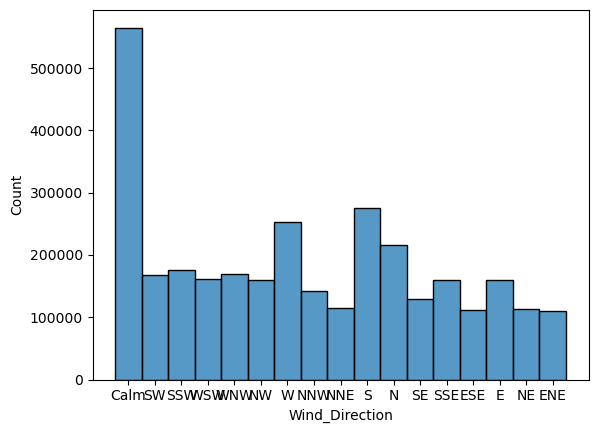

In [33]:
sns.histplot(data = US_Accidents, x="Wind_Direction")
US_Accidents["Wind_Direction"].describe()

### Wind speed

In [34]:
US_Accidents["Wind_Speed(mph)"].info()
#US_Accidents["Wind_Speed(mph)"].head(10)
US_Accidents["Wind_Speed(mph)"].describe()

<class 'pandas.core.series.Series'>
Int64Index: 3413597 entries, 0 to 3513615
Series name: Wind_Speed(mph)
Non-Null Count    Dtype  
--------------    -----  
2977990 non-null  float64
dtypes: float64(1)
memory usage: 52.1 MB


count    2.977990e+06
mean     8.215139e+00
std      5.125145e+00
min      0.000000e+00
25%      5.000000e+00
50%      7.000000e+00
75%      1.150000e+01
max      9.840000e+02
Name: Wind_Speed(mph), dtype: float64

<AxesSubplot:>

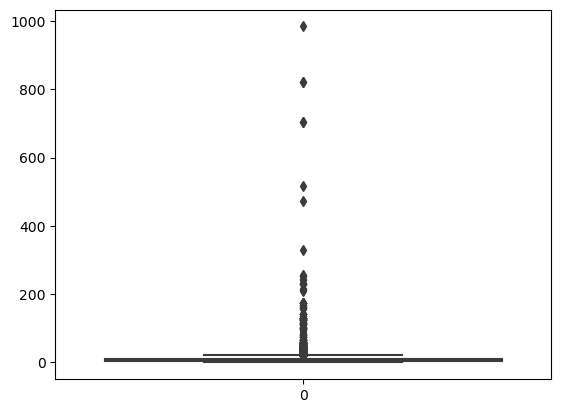

In [35]:
#sns.histplot(data = US_Accidents, x="Wind_Speed(mph)")
US_Accidents["Wind_Speed(mph)"].describe()
sns.boxplot(US_Accidents["Wind_Speed(mph)"], color="#bd0606") 

In [36]:
# Remove exteme winds
def remove_extreme_mph(mph):
    ''' Removes winds that are stronger than 250 mph, hurricanes max windspeeds is around 250 mph'''
    my_list = []
    for x in mph:
        if x > 250:
            x = np.nan
        my_list.append(x)
    return my_list
US_Accidents["Wind_Speed(mph)"] = remove_extreme_mph(US_Accidents["Wind_Speed(mph)"])

In [37]:
# convert mph to the wind force
def windforces(mph):
    ''' Takes in the wind speed in mph and coverts it to the wind force '''
    my_list = []
    for x in mph:
        if x < 1:
            x = 0
        elif x >= 1 and x < 4:
            x = 1
        elif x >= 4 and x < 8: 
            x = 2
        elif x >= 8 and x < 13:
            x = 3
        elif x >= 13 and x < 19:
            x = 4
        elif x >= 19 and x < 25:
            x = 5
        elif x >= 25 and x < 32:
            x = 6
        elif x >= 32 and x < 39:
            x = 7
        elif x >= 39 and x < 47:
            x = 8
        elif x >= 47 and x < 55:
            x = 9
        elif x >= 55 and x < 64:
            x = 10
        elif x >= 64 and x < 73:
            x = 11
        elif x >= 73:
            x = 12
        my_list.append(x)
    return my_list
 
US_Accidents["Wind_Force"] = windforces(US_Accidents["Wind_Speed(mph)"])                

<AxesSubplot:xlabel='Wind_Force', ylabel='Count'>

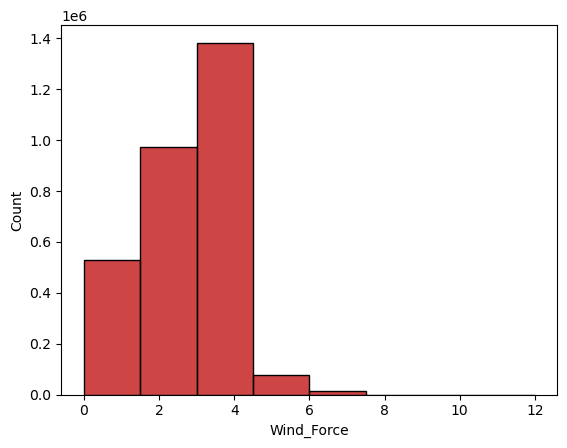

In [38]:
sns.histplot(data = US_Accidents, x="Wind_Force", color="#bd0606", binwidth = 1.5 )

### Precipitation(in)

In [74]:
US_Accidents["Precipitation(in)"].info()
#US_Accidents["Precipitation(in)"].head(10)
#US_Accidents["Precipitation(in)"].describe()

<class 'pandas.core.series.Series'>
Int64Index: 3413597 entries, 0 to 3513615
Series name: Precipitation(in)
Non-Null Count    Dtype  
--------------    -----  
1450021 non-null  float64
dtypes: float64(1)
memory usage: 52.1 MB


<AxesSubplot:>

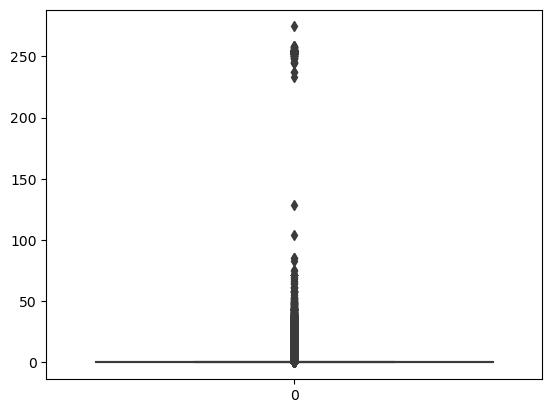

In [73]:
#sns.histplot(data = US_Accidents, x="Precipitation(in)")
US_Accidents["Precipitation(in)"].describe()
sns.boxplot(US_Accidents["Precipitation(mm)"], color="#bd0606") 

#### Check which states have the extreme amount of rain fall and see if this would be possible

In [41]:
df_rain = US_Accidents[US_Accidents["Precipitation(in)"] > 15]
df_rain["State"]

945958     TN
3078222    CA
Name: State, dtype: object

#### Max rain fall in Tennessee and California do not match the extreme rain fall recorderd, therefore these values will be deleted

In [42]:
def remove_extreme_rain(rain):
    ''' Removes values when the rainfall is above 15 inches '''
    my_list = []
    for r in rain:
        if r > 15:
            r = np.NaN
        my_list.append(r)
    return my_list
US_Accidents["Precipitation(in)"] = remove_extreme_rain(US_Accidents["Precipitation(in)"])

#### Make a new column  that shows precipitation in mm

In [43]:
def inch_to_mm(inch):
    my_list = []
    for i in inch:
        my_list.append(i * 25.4)
    return my_list
US_Accidents["Precipitation(mm)"] = inch_to_mm(US_Accidents["Precipitation(in)"])

### Weather condition

In [58]:
US_Accidents["Weather_Condition"].info()
US_Accidents["Weather_Condition"] = US_Accidents["Weather_Condition"].fillna('N/A').astype("string")
US_Accidents["Weather_Condition"] = US_Accidents["Weather_Condition"].astype("string")
#US_Accidents["Weather_Condition"].describe()
pd.unique(US_Accidents["Weather_Condition"])


<class 'pandas.core.series.Series'>
Int64Index: 3413597 entries, 0 to 3513615
Series name: Weather_Condition
Non-Null Count    Dtype 
--------------    ----- 
3413597 non-null  object
dtypes: object(1)
memory usage: 52.1+ MB


<StringArray>
[                      'Rain',                     'Cloudy',
                       'Snow',                      'Fuzzy',
                      'Clear',              'Freezing Rain',
                    'Drizzle',                        'N/A',
             'Freezing Fuzzy',               'Thunderstorm',
                      'Windy',               'Cloudy Windy',
                 'Rain Windy',                 'Snow Windy',
                'Fuzzy Windy',                    'Tornado',
 'Thunderstorm Freezing Rain']
Length: 17, dtype: string

#### Clean up the weather conditions and make less clearer weather condition groups

In [59]:
text1 = US_Accidents["Weather_Condition"]
#text1 = text1.drop_duplicates()

In [60]:
#Remove / from strings
def remove_extra_words(words):
    my_list = []
    for i in words:
        i = i.replace("Showers in the Vicinity", "Rain")
        i = i.replace(" / ", " ")
        i = i.replace(" and ", " ")
        i = i.replace(" of ", " ")
        i = i.replace(" in ", " ")
        i = i.replace(" the ", " ")
        i = i.replace(" with ", " ").replace(" s ", "")
        i = i.replace("Precipitation", "")
        i = i.replace("Light", "").replace("Mostly", "").replace("Scattered", "").replace("Partly", "").replace("Grains", "")
        i = i.replace("Small", "").replace("Nearby", "").replace("Partial", "").replace("Heavy", "").replace("Shallow", "")
        i = i.replace("Squalls", "").replace("Whirlwinds", "").replace("Patches", "").replace("Showers", "").replace("Shower", "").replace("Whirls", "")
        my_list.append(i)
    return my_list
text1 = remove_extra_words(text1)

In [61]:
US_Accidents["Weather_Condition"] = remove_extra_words(US_Accidents["Weather_Condition"])

In [62]:
def similar_words(words):
    my_list = []
    for word in words:
        word = word.replace("Vicinity", "").replace("Snow Snow", "Snow")
        word = word.replace("Overcast", "Cloud").replace("Clouds", "Cloud").replace("Cloudy", "Cloud")
        word = word.replace("Cloud", "Cloudy")
        word = word.replace("Thunderstorms", "Thunderstorm").replace("T-Storm", "Thunderstorm").replace("Thunder Hail Windy", "Thunderstorm").replace("Rain Thunder", "Thunderstorm").replace("Thunder Windy", "Thunderstorm").replace("Thunderstorm Rain", "Thunderstorm").replace("Thunderstorm Windy", "Thunderstorm")
        word = word.replace("Thunder Snow", "Freezing Thunderstorm").replace("Thunderstorm Freezing Rain", "Freezing Thunderstorm").replace("Thunderstorm Snow", "Freezing Thunderstorm").replace("Snow Thunder", "").replace("Freezing Thunderstorm Windy", "Freezing Thunderstorm").replace("Thunder Freezing Rain", "Freezing Thunderstorm")
        word = word.replace("Funnel Cloudy", "Cloudy Windy")
        word = word.replace("Pellets", "").replace("Ice", "Icy")
        word = word.replace("Fog", "Fuzzy").replace("Smoke", "Fuzzy").replace("Sand Dust", "Fuzzy").replace("Mist", "Fuzzy").replace("Sand", "Fuzzy").replace("Dust", "Fuzzy").replace("Vulcanic Ash", "Fuzzy").replace("Fog Windy", "Fuzzy").replace("Haze", "Fuzzy").replace("Volcanic Ash", "Fuzzy")
        word = word.replace("Drifting Snow", "Snow").replace("Snow Grains", "Snow").replace("Snow Windy", "Snow").replace("Sleet", "Snow").replace("Wintry Mix", "Snow").replace("Snow Snow", "Snow")
        word = word.replace("Widespread", "").replace("Fair", "").replace("Blowing", "").replace("Low", "")
        word = word.replace("Freezing Rain Windy", "Freezing Rain").replace("Hail", "Freezing Rain").replace("Freezing Drizzle", "Freezing Rain")
        word = word.replace("Drizzle Fuzzy", "Drizzle").replace("Drizzle Windy","Drizzle").replace("Fuzzy Windy", "Fuzzy").replace("Icy", "Snow")
        word = word.replace("Rain Snow", "Snow").replace("Thunder", "Thunderstorm").replace("Thunderstormstorm", "Thunderstorm").replace("Thunderstorm Freezing Rain", "Freezing Thunderstorm").replace("Thunderstorm Snow Windy", "Freezing Thunderstorm").replace("Freezing Thunderstorm", "Thunderstorm")
        word = word.replace("  ", " ")
        word = word.lstrip().rstrip()
        if len(word) ==0:
            word = "N/A"
        my_list.append(word)
    return my_list
text1 = similar_words(text1)

In [63]:
US_Accidents["Weather_Condition"] = similar_words(US_Accidents["Weather_Condition"])

In [64]:
#list(set(text1))
list(set(US_Accidents["Weather_Condition"]))

['Fuzzy',
 'Freezing Fuzzy',
 'Cloudy',
 'Thunderstorm',
 'Tornado',
 'Rain Windy',
 'Rain',
 'N/A',
 'Cloudy Windy',
 'Clear',
 'Windy',
 'Snow',
 'Drizzle',
 'Freezing Rain']

In [65]:
#Counter(text1)
Counter(US_Accidents["Weather_Condition"])

Counter({'Rain': 229105,
         'Cloudy': 1590058,
         'Snow': 59913,
         'Fuzzy': 78014,
         'Clear': 784599,
         'Freezing Rain': 3032,
         'Drizzle': 15050,
         'N/A': 603148,
         'Freezing Fuzzy': 959,
         'Thunderstorm': 28151,
         'Windy': 7665,
         'Cloudy Windy': 11011,
         'Rain Windy': 2889,
         'Tornado': 3})

## Explorative data analysis

#### Create subset of data 

In [66]:
US_Weather = US_Accidents[["Weather_Timestamp", "Temperature(C)", "Wind_Chill(C)", "Humidity(%)", "Pressure(in)", "Visibility(km)", "Wind_Direction", "Wind_Speed(mph)", "Wind_Force", "Precipitation(in)", "Precipitation(mm)", "Weather_Condition", "Severity", "Distance(mi)"]]

In [67]:
US_Weather.head(5)

,Weather_Timestamp,Temperature(C),Wind_Chill(C),Humidity(%),Pressure(in),Visibility(km),Wind_Direction,Wind_Speed(mph),Wind_Force,Precipitation(in),Precipitation(mm),Weather_Condition,Severity,Distance(mi)
0,2016-02-08 05:58:00,2.722222,NaN,91.0,29.68,16.093440,Calm,NaN,NaN,0.02,0.508,Rain,3,0.01
1,2016-02-08 05:51:00,3.277778,NaN,100.0,29.65,16.093440,Calm,NaN,NaN,0.00,0.000,Rain,2,0.01
2,2016-02-08 06:56:00,2.222222,0.722222,100.0,29.67,16.093440,SW,3.5,1.0,NaN,NaN,Cloudy,2,0.01
3,2016-02-08 07:38:00,1.722222,-0.555556,96.0,29.64,14.484096,SW,4.6,2.0,NaN,NaN,Cloudy,3,0.01
4,2016-02-08 07:53:00,2.222222,0.722222,89.0,29.65,9.656064,SW,3.5,1.0,NaN,NaN,Cloudy,2,0.01


#### Plot heatmap to visualize possible correlations

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0.5, 0, 'Temperature(C)'),
  Text(1.5, 0, 'Wind_Chill(C)'),
  Text(2.5, 0, 'Humidity(%)'),
  Text(3.5, 0, 'Pressure(in)'),
  Text(4.5, 0, 'Visibility(km)'),
  Text(5.5, 0, 'Wind_Speed(mph)'),
  Text(6.5, 0, 'Wind_Force'),
  Text(7.5, 0, 'Precipitation(in)'),
  Text(8.5, 0, 'Precipitation(mm)'),
  Text(9.5, 0, 'Severity'),
  Text(10.5, 0, 'Distance(mi)')])

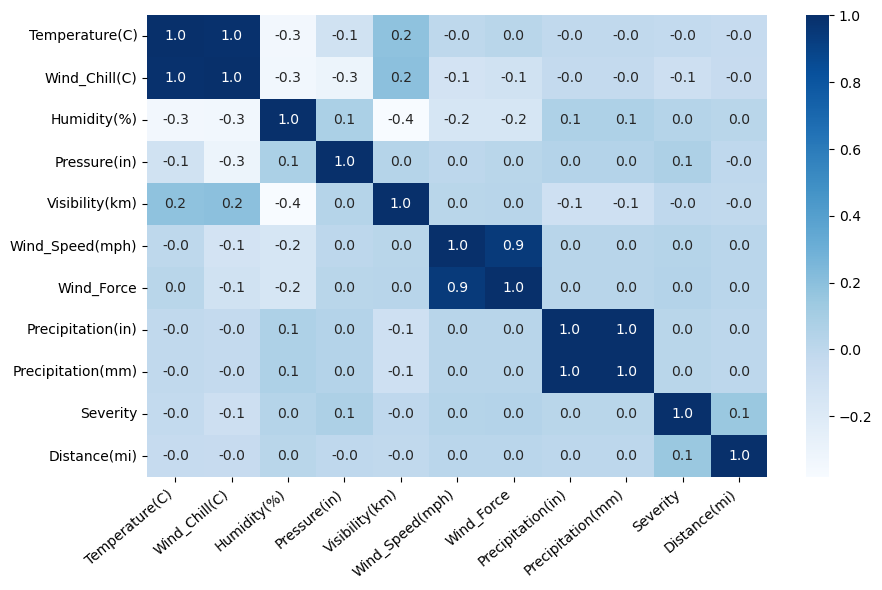

In [68]:
corr_matrix = US_Weather.corr()
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(corr_matrix, annot=True, cmap="Blues",fmt='.1f')
plt.xticks(rotation=40, ha='right') 

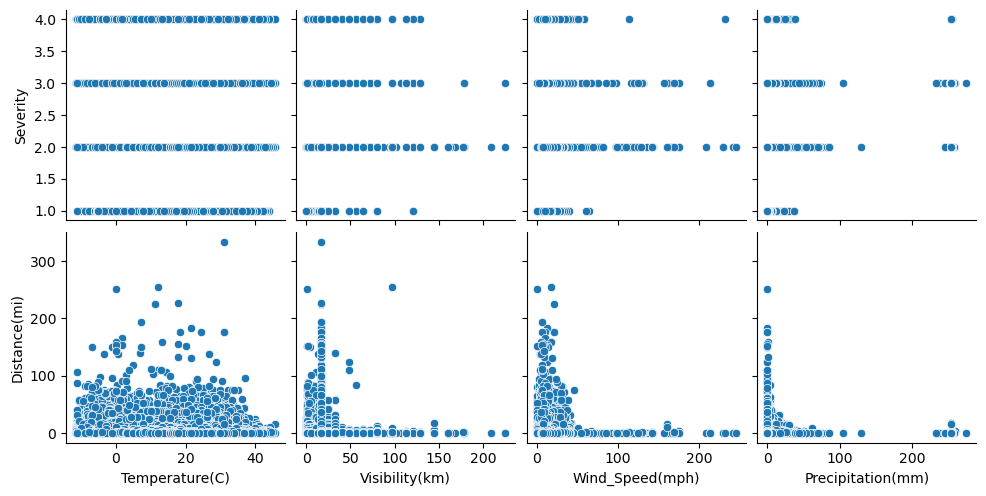

In [69]:
sns.pairplot(US_Weather, 
            x_vars=["Temperature(C)", "Visibility(km)", "Wind_Speed(mph)", "Precipitation(mm)"],
            y_vars=["Severity", "Distance(mi)"])

<AxesSubplot:xlabel='Severity', ylabel='Visibility(km)'>

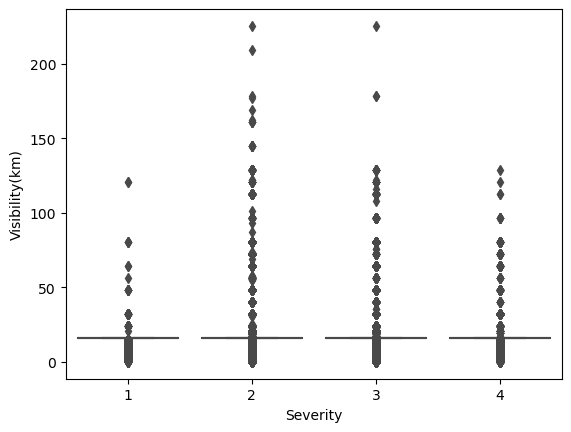

In [70]:
sns.boxplot(data=US_Weather, x="Severity", y="Visibility(km)", color="#3e6fb5") 
#sns.boxplot(data=US_Weather, x="Severity", y="Precipitation(mm)", color="#3e6fb5") 

In [71]:
sns.barplot(data=df_sorted, y="Visibility(km)", x="Severity", palette="Blues")

NameError: name 'df_sorted' is not defined

In [ ]:
df_sorted = US_Accidents.sort_values("Weather_Condition")

In [ ]:
#sns.boxplot(data=US_Weather, x="Weather_Condition", y="Severity", color="#3e6fb5") 
#plt.xticks(rotation=40, ha='right') 

sns.barplot(data=df_sorted, y="Weather_Condition", x="Severity", palette="Blues")

In [ ]:
my_list = []
string = ""
if US_Accidents["Rain"][341368] == True:
        string += "Wind "
        my_list.append(string)
else:
    my_list.append("nope")
my_list

In [ ]:
#df = pd.DataFrame({})
#df= US_Accidents[["Weather_Condition", "Rain"]]
#df["Rain"]

In [ ]:
#df2 = df.loc[(df["Rain"] == True), "Weather_Condition"] == "Rain"
#df2

In [ ]:
weather_con.loc[weather_con["Wind_Speed(mph)"] >= 25, "Wind"] = True

In [ ]:
weather_con[(weather_con["Temperature(C)"] < 0) & (weather_con["Precipitation(mm)"] > 0)]

In [ ]:

my_list = []
count = 0
for rows in range(0,800):
    string = ""
    if US_Accidents["Rain"][count] == True:
        string += "Rain "
        
#    if US_Accidents["Wind"][count] == True:
#        string += "Wind "
#    if US_Accidents["Snow"][count] == True:
#        string += "Snow "
#    if US_Accidents["Freeze"][count] == True:
#        string += "Freeze "
#    if US_Accidents["Drizzle"][count] == True:
#        string += "Drizzle "
#    if US_Accidents["Thunder"][count] == True:
#        string += "Thunder "
#    if US_Accidents["Tornado"][count] == True:
#        string += "Tornado "
    count += 1
    my_list.append(string)
        
my_list

In [ ]:
#sns.boxplot(data=US_Weather, x="Weather_Condition", y="Distance(mi)", color="#3e6fb5") 
#plt.xticks(rotation=40, ha='right') 

sns.barplot(data=df_sorted, y="Weather_Condition", x="Distance(mi)", palette="Blues")

### Calculate Percentage of weather conditions

#### Make a cleaner version of the weather conditions and make boolean columns showing weather a certain conditions is present or not

In [ ]:
text2 = US_Accidents["Weather_Condition"]
list(set(text2))

def remove_extra_words(words):
    my_list = []
    for i in words:
        i = i.replace("Showers in the Vicinity", "Rain")
        i = i.replace(" / ", " ")
        i = i.replace(" and ", " ")
        i = i.replace(" of ", " ")
        i = i.replace(" in ", " ")
        i = i.replace(" the ", " ")
        i = i.replace(" with ", " ")
        i = i.replace("Precipitation", "")
        i = i.replace("Light", "").replace("Mostly", "").replace("Scattered", "").replace("Partly", "").replace("Grains", "")
        i = i.replace("Small", "").replace("Nearby", "").replace("Partial", "").replace("Heavy", "").replace("Shallow", "")
        i = i.replace("Squalls", "").replace("Patches", "")
        i = i.lstrip().rstrip()
        if len(i) ==0:
            i = "N/A"
        my_list.append(i)
    return my_list
text2 = remove_extra_words(text2)

def asign_similiar(words):
    my_list = []
    for word in words:
        word = word.replace("Overcast", "Cloud").replace("Clouds", "Cloud").replace("Cloudy", "Cloud")
        word = word.replace("Cloud", "Cloudy")
        word = word.replace("Thunderstorms", "Thunderstorm").replace("T-Storm", "Thunderstorm").replace("Thunderstorm", "Thunder")
        word = word.replace("Hail", "Freezing")
        word = word.replace("Funnel", "Windy").replace("Whirlwinds", "Windy").replace("Whirls", "Windy")
        word = word.replace("Pellets", "").replace("Ice", "Freezing")
        word = word.replace("Fog", "Fuzzy").replace("Smoke", "Fuzzy").replace("Sand Dust", "Fuzzy").replace("Mist", "Fuzzy").replace("Sand", "Fuzzy").replace("Dust", "Fuzzy").replace("Volcanic Ash", "Fuzzy").replace("Haze", "Fuzzy")
        word = word.replace("Drifting Snow", "Snow").replace("Snow Grains", "Snow").replace("Sleet", "Snow").replace("Wintry Mix", "Snow").replace("Snow Snow", "Snow")
        word = word.replace("Widespread", "").replace("Fair", "").replace("Blowing", "Windy").replace("Low", "")
        word = word.lstrip().rstrip()
        if len(word) ==0:
            word = "N/A"
        my_list.append(word)
    return my_list
text3 = asign_similiar(text2)

list(set(text3))

def assign_boolean(words):
    list_rain = []
    list_wind = []
    list_snow = []
    list_cloud = []
    list_freeze = []
    list_fuzz = []
    list_drizzle = []
    list_thunder = []
    list_tornado = []
    for word in words:
        if "Rain" in word:
            list_rain.append(True)
        else:
            list_rain.append(False)
        if "Windy" in word:
            list_wind.append(True)
        else:
            list_wind.append(False)
        if "Snow" in word:
            list_snow.append(True)
        else:
            list_snow.append(False)
        if "Cloudy" in word:
            list_cloud.append(True)
        else:
            list_cloud.append(False)
        if "Freezing" in word:
            list_freeze.append(True)
        else:
            list_freeze.append(False)
        if "Fuzzy" in word:
            list_fuzz.append(True)
        else:
            list_fuzz.append(False)
        if "Drizzle" in word:
            list_drizzle.append(True)
        else:
            list_drizzle.append(False)
        if "Thunder" in word:
            list_thunder.append(True)
        else:
            list_thunder.append(False)
        if "Tornado" in word:
            list_tornado.append(True)
        else:
            list_tornado.append(False)
    return list_rain, list_wind, list_snow, list_cloud, list_freeze, list_fuzz, list_drizzle, list_thunder, list_tornado
text4 = assign_boolean(text3)

Rain = text4[0]
Wind = text4[1]  
Snow = text4[2] 
Cloud = text4[3]  
Freeze = text4[4]  
Fuzzy = text4[5]  
Drizzle = text4[6]  
Thunder = text4[7]  
Tornado = text4[8]

US_Accidents["Rain"] = Rain
US_Accidents["Wind"] = Wind
US_Accidents["Snow"] = Snow
US_Accidents["Cloud"] = Cloud
US_Accidents["Freeze"] = Freeze
US_Accidents["Fuzzy"] = Fuzzy
US_Accidents["Drizzle"] = Drizzle
US_Accidents["Thunder"] = Thunder
US_Accidents["Tornado"] = Tornado

contribution_weather[1].index.values

contribution_weather[1].values

#### Add all conditions but remove when lower than 1 percent

In [282]:
weather_con = US_Accidents[["Rain", "Wind", "Snow", "Cloud", "Freeze", "Fuzzy", "Drizzle", "Thunder", "Tornado", "Severity"]]

total = weather_con.groupby("Severity").count()
total_true = weather_con.groupby("Severity").sum()

percent_weather = total_true / total * 100

sum_per = percent_weather.sum(axis =1)

df = pd.DataFrame({})
weather_list = ["Rain", "Wind", "Snow", "Cloud", "Freeze", "Fuzzy", "Drizzle", "Thunder", "Tornado"]
count = 0
for item in weather_list:
    name = weather_list[count]
    df[name] = sum_per
    count += 1
contribution_weather = percent_weather / df * 100
contribution_weather = contribution_weather.transpose()

contribution_weather = contribution_weather[contribution_weather[1] > 0.5]

#### Remove wind and do the same thing as above with adjusted columns

In [404]:
#Make new data set with relevant data
weather_con = US_Accidents[["Rain", "Wind", "Snow", "Freeze", "Fuzzy", "Drizzle", "Thunder", "Tornado", "Severity", "Wind_Speed(mph)", "Temperature(C)", "Precipitation(mm)", "Visibility(km)"]]

#Adjust to only have true for wind when wind speed is higher that 25 mph
weather_con.loc[weather_con["Wind_Speed(mph)"] < 25, "Wind"] = False
weather_con.loc[weather_con["Wind_Speed(mph)"] >= 25, "Wind"] = True

#Check if there is no precipitation but snow or rain is true --> false true's AND adjust
#Rain
weather_con.loc[(weather_con["Rain"] == True) & (weather_con["Precipitation(mm)"] <= 0), "Rain"] = False
#Snow
weather_con.loc[(weather_con["Snow"] == True) & (weather_con["Precipitation(mm)"] <= 0), "Snow"] = False

#Visibility/Fuzzy --> traffic has problems when visibility is lower than 400 meters
weather_con.loc[(weather_con["Fuzzy"] == False) & (weather_con["Visibility(km)"] <= 0.4), "Fuzzy"] = True
weather_con.loc[(weather_con["Fuzzy"] == True) & (weather_con["Visibility(km)"] > 0.4), "Fuzzy"] = False

#Remove- not relevant anymore
weather_con = weather_con.drop("Wind_Speed(mph)", axis=1)
weather_con = weather_con.drop("Temperature(C)", axis=1)
weather_con = weather_con.drop("Precipitation(mm)", axis=1)
weather_con = weather_con.drop("Visibility(km)", axis=1)

#Calculate the total values in each column and how many are true
total = weather_con.groupby("Severity").count()
total_true = weather_con.groupby("Severity").sum()
#Calculate pecentage true
percent_weather = total_true / total * 100

#Add percentages per severity
sum_per = percent_weather.sum(axis =1)

#Make dataframe with repeated sum_per so it can be used to calculate the distribution
df = pd.DataFrame({})
weather_list = ["Rain", "Wind", "Snow", "Freeze", "Fuzzy", "Drizzle", "Thunder", "Tornado"]
count = 0
for item in weather_list:
    name = weather_list[count]
    df[name] = sum_per
    count += 1
    
#Distribution is calculated my divding the oiginal percentages by total percentage * 100
contribution_weather = percent_weather / df * 100
contribution_weather = contribution_weather.transpose()
contribution_weather = contribution_weather[contribution_weather[1] > 0.5]


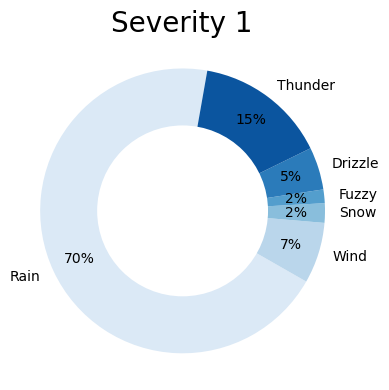

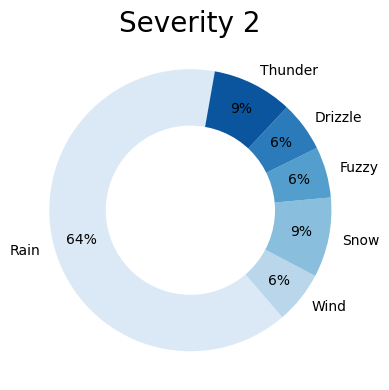

In [413]:
# Make pie chart Severity 1
data = contribution_weather[1]
labels = contribution_weather.index.values
colors = sns.color_palette("Blues")
fig1, ax1 = plt.subplots(figsize = (4, 4))
ax1.pie(data, colors = colors, labels=labels, 
        autopct='%.0f%%', startangle=80,  
        radius=1, pctdistance=0.8, textprops={"fontsize":10})
plt.title("Severity 1", fontsize =20)
#draw circle
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout() 


# Make pie chart Severity 2
data = contribution_weather[2]
labels = contribution_weather.index.values
colors = sns.color_palette("Blues")
fig1, ax1 = plt.subplots(figsize = (4, 4))
ax1.pie(data, colors = colors, labels=labels, 
        autopct='%.0f%%', startangle=80,  
        radius=1, pctdistance=0.8, textprops={"fontsize":10})
plt.title("Severity 2", fontsize =20)
#draw circle
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()  


#### Do same but for severity 3 & 4

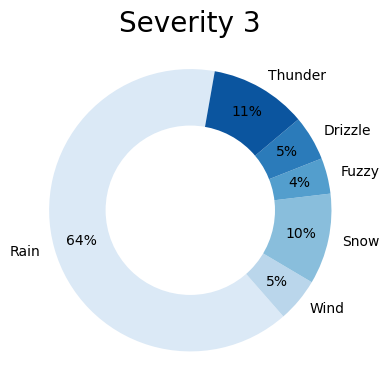

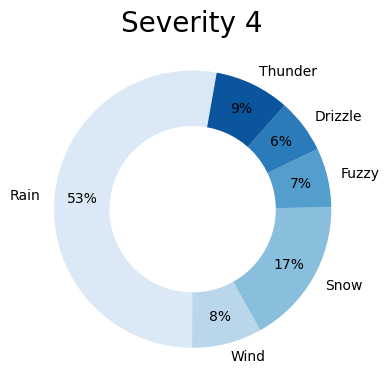

In [414]:
# Make pie chart Severity 3
data = contribution_weather[3]
labels = contribution_weather.index.values
colors = sns.color_palette("Blues")
fig1, ax1 = plt.subplots(figsize = (4, 4))
ax1.pie(data, colors = colors, labels=labels, 
        autopct='%.0f%%', startangle=80, 
        radius=1, pctdistance=0.8, textprops={"fontsize":10})
plt.title("Severity 3", fontsize =20)
#draw circle
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout() 


# Make pie chart Severity 4
data = contribution_weather[4]
labels = contribution_weather.index.values
colors = sns.color_palette("Blues")
fig1, ax1 = plt.subplots(figsize = (4, 4))
ax1.pie(data, colors = colors, labels=labels, 
        autopct='%.0f%%', startangle=80, 
        radius=1, pctdistance=0.8, textprops={"fontsize":10})
plt.title("Severity 4", fontsize =20)
#draw circle
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout() 


#### Do same as piecharts but make a barplot and restructure dataframe to do so

C:\Users\ilsev\AppData\Local\Temp\ipykernel_14276\2780364345.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ex = df_try.append(df_try2)
C:\Users\ilsev\AppData\Local\Temp\ipykernel_14276\2780364345.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ex = df_ex.append(df_try3)
C:\Users\ilsev\AppData\Local\Temp\ipykernel_14276\2780364345.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ex = df_ex.append(df_try4)


<AxesSubplot:xlabel='Weather', ylabel='percentage'>

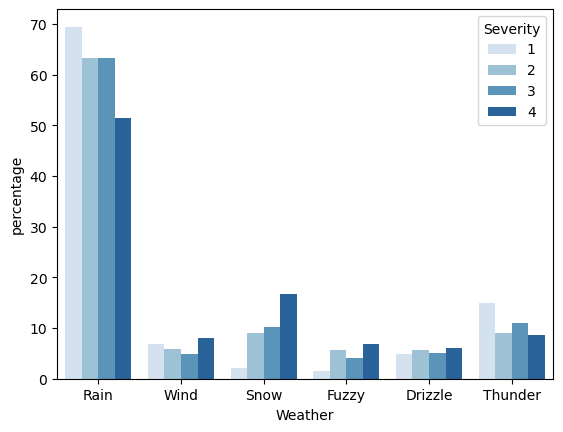

In [415]:
df_try = pd.DataFrame({})
df_try["Weather"] = contribution_weather[1].index.values
df_try["Severity"] = [1 , 1, 1, 1, 1, 1]
df_try["percentage"] = contribution_weather[1].values

df_try2 = pd.DataFrame({})
df_try2["Weather"] = contribution_weather[2].index.values
df_try2["Severity"] = [2, 2, 2, 2, 2, 2]
df_try2["percentage"] = contribution_weather[2].values

df_try3 = pd.DataFrame({})
df_try3["Weather"] = contribution_weather[3].index.values
df_try3["Severity"] = [3, 3, 3, 3, 3, 3]
df_try3["percentage"] = contribution_weather[3].values

df_try4 = pd.DataFrame({})
df_try4["Weather"] = contribution_weather[4].index.values
df_try4["Severity"] = [4, 4, 4, 4, 4, 4]
df_try4["percentage"] = contribution_weather[4].values

df_ex = df_try.append(df_try2)
df_ex = df_ex.append(df_try3)
df_ex = df_ex.append(df_try4)

sns.barplot(data=df_ex, x='Weather', y='percentage', hue= "Severity", palette="Blues")
